# SYSID - Trabalho (ML - MISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

# Modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_trabalho/Volve-Dataset/data/volve_compiled.pkl


In [3]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


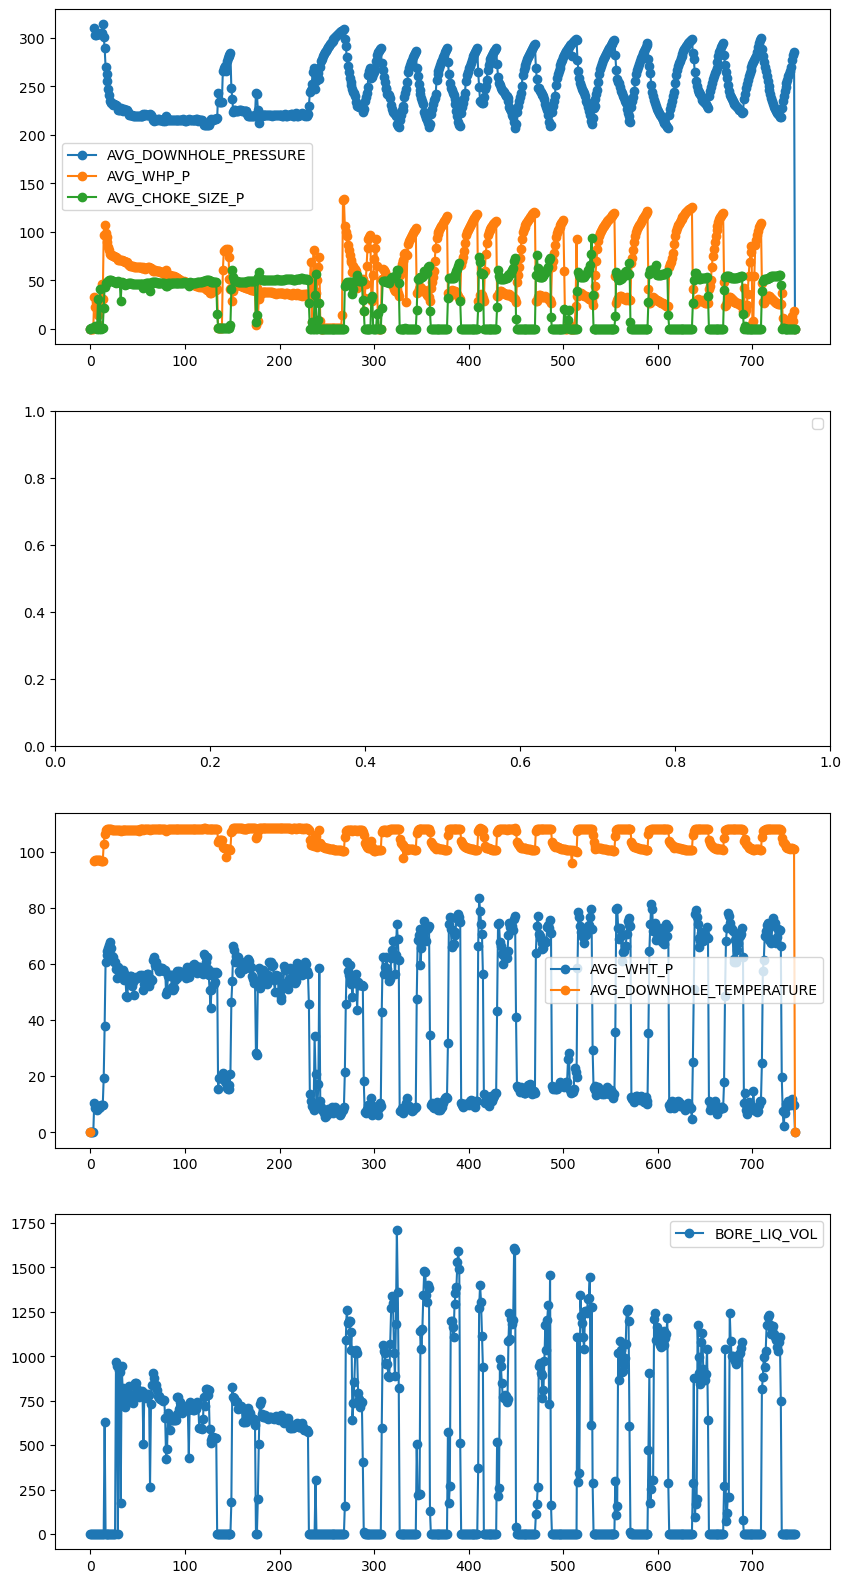

In [4]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [5]:
data_case = data_case.loc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [6]:
p_train = 0.8 #80% treino

### 1.2 - Separando os conjuntos

In [7]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [8]:
print(
    X1_tr.shape,
    X1_te.shape
)

(574, 5) (718, 5)


In [9]:
y_scale = MinMaxScaler()
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

In [10]:
models = []

In [11]:
models_ml = [
    ('LinReg',  LinearRegression(copy_X=True)), #ARX Equivalent
    ('PolyReg', Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivalent
    ('SVM',     SVR(max_iter=-1)),
    ('KNN',     KNeighborsRegressor()),
    ('DT',      DecisionTreeRegressor(random_state=rs)),
    ('RF',      RandomForestRegressor(random_state=rs)),
]

n_models = len(models)

In [12]:
parameters = [
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : stats.randint(2,10),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(6,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
]

In [13]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [14]:
n_iter = 100 #Numero de iterações do rdmsearch 

for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch, 
        preprocessor=MinMaxScaler(),
        #expansor=PolynomialFeatures(degree=2)
        )
    
    models.append(
        (model[0], sidmodel)
    )

n_models = len(models)

In [15]:
results = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
    'PARS':[]
}

order_progression = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
}

Starting evaluation of model: LinReg
    Trying order: 2
        R2 score OSA (Train): 0.7897726253354066
        R2 score OSA (Test): 0.7888098691781511
        R2 score FS (Train): 0.5548511079601762
        R2 score FS (Test): 0.5657875808623858
    Trying order: 3
        R2 score OSA (Train): 0.7979001927030601
        R2 score OSA (Test): 0.7974474684931869
        R2 score FS (Train): 0.556535232631743
        R2 score FS (Test): 0.5704946453094659
    Trying order: 4
        R2 score OSA (Train): 0.797963873127211
        R2 score OSA (Test): 0.7974962726105529
        R2 score FS (Train): 0.5569967815189469
        R2 score FS (Test): 0.5709373207417365
    Trying order: 5
        R2 score OSA (Train): 0.8020425814271792
        R2 score OSA (Test): 0.8010280157731172
        R2 score FS (Train): 0.5524883110434009
        R2 score FS (Test): 0.5672316252983627
    Trying order: 6
        R2 score OSA (Train): 0.805069846011053
        R2 score OSA (Test): 0.8033036467172303
 

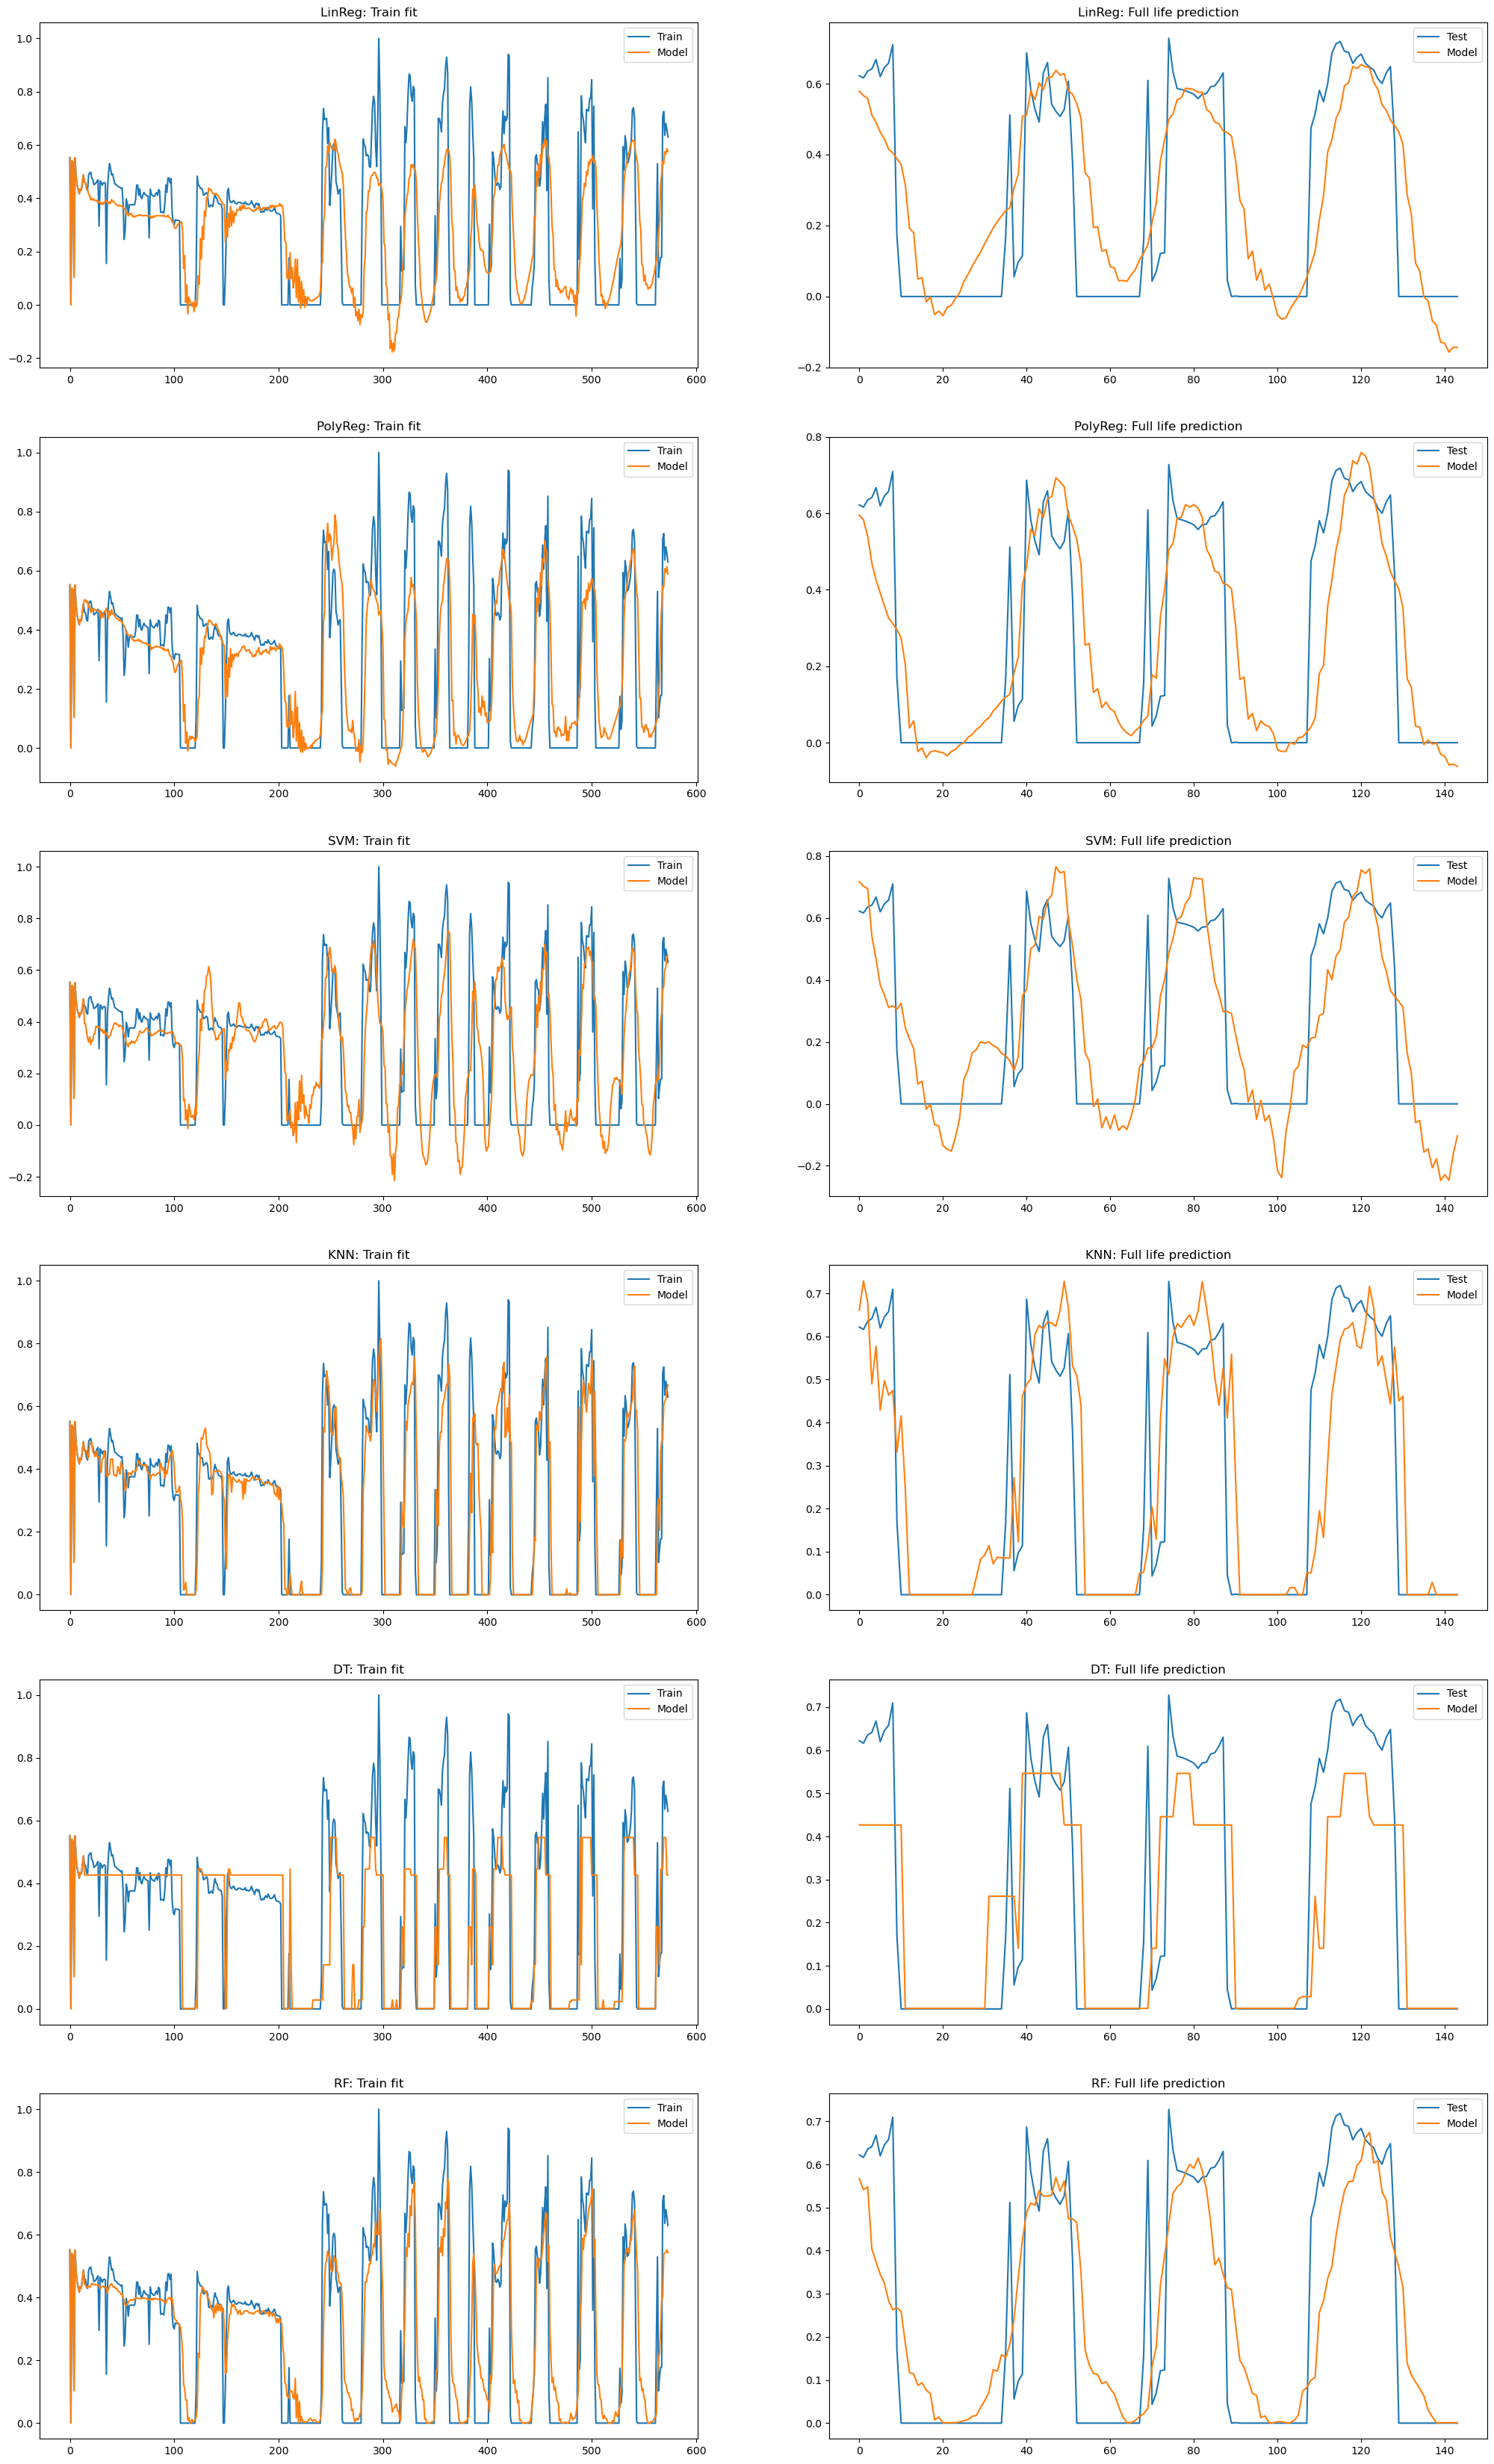

In [16]:

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))
orders = range(2,15)
#Loop principal, iterando sobre as listas
for model, ax in zip(models, axs):
    
    model_name, sidmodel = model

    print('Starting evaluation of model: {}'.format(model_name))
    
    t0 = datetime.now()

    best_r2_tr_fs = 1e6
    best_r2_te_fs = 1e6
    best_r2_tr_osa = 1e6
    best_r2_te_osa = 1e6
    best_order = 0
    best_model = None
    
    for order in orders:
        print(f'    Trying order: {order}')
        try:
            sidmodel.nX = order
            sidmodel.ny = order
        except Exception:
            sidmodel.nx = order
            sidmodel.ny = order
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X1_tr, y_tr)
        r2_tr_osa = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1))
        r2_te_osa = r2_score(y_te, sidmodel.predict(X1_te, y=y_te, steps_ahead=1))
        r2_tr_fs = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
        r2_te_fs = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
        if np.abs(r2_tr_fs - 1) < np.abs(best_r2_tr_fs - 1):
            best_r2_tr_fs = r2_tr_fs
            best_r2_te_fs = r2_te_fs
            best_r2_tr_osa = r2_tr_osa
            best_r2_te_osa = r2_te_osa
            best_order = order
            best_model = sidmodel
        order_progression['MODEL'].append(model_name)
        order_progression['ORDER'].append(order)
        order_progression['R2 TRAIN OSA'].append(r2_tr_osa)
        order_progression['R2 TEST OSA'].append(r2_te_osa)
        order_progression['R2 TRAIN FS'].append(r2_tr_fs)
        order_progression['R2 TEST FS'].append(r2_te_fs)
        order_progression['MODEL OBJ'].append(sidmodel)
        print('        R2 score OSA (Train):', r2_tr_osa)
        print('        R2 score OSA (Test):', r2_te_osa)
        print('        R2 score FS (Train):', r2_tr_fs)
        print('        R2 score FS (Test):', r2_te_fs)
            

    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Best Order:', best_order)
    print('    R2 score OSA (Train):', best_r2_tr_osa)
    print('    R2 score OSA (Test):', best_r2_te_osa)
    print('    R2 score FS (Train):', best_r2_tr_fs)
    print('    R2 score FS (Test):', best_r2_te_fs)

    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(sidmodel.predict(X1_tr, y=y_tr), label='Model') 
    ax[0].set_title(f'{model_name}: Train fit')
    ax[0].legend()
    hist = ax[1].plot(y_te[n_train:,:], label='Test')
    hist = ax[1].plot(sidmodel.predict(X1_te, y=y_te)[n_train:,:], label='Model')
    ax[1].set_title(f'{model_name}: Full life prediction')
    ax[1].legend()
    print()
    
    results['MODEL'].append(model_name)
    results['ORDER'].append(best_order)
    results['R2 TRAIN OSA'].append(best_r2_tr_osa)
    results['R2 TEST OSA'].append(best_r2_te_osa)
    results['R2 TRAIN FS'].append(best_r2_tr_fs)
    results['R2 TEST FS'].append(best_r2_te_fs)
    results['MODEL OBJ'].append(sidmodel)
    results['PARS'].append(sidmodel.estimator.best_params_)

In [17]:
pd.DataFrame(results)

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ,PARS
0,LinReg,4,0.797964,0.797496,0.556997,0.570937,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
1,PolyReg,2,0.802841,0.801865,0.638416,0.645308,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'Reg__positive': True}
2,SVM,13,0.817513,0.807563,0.622412,0.636245,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 0.1467581900194581, 'degree': 3, 'gamma'..."
3,KNN,14,1.000000,0.941824,0.683640,0.681125,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 6, 'weights': 'distance'}"
4,DT,11,0.857602,0.839998,0.641343,0.620211,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 17, 'max_features': 0.9868299345..."
5,RF,11,0.924726,0.892289,0.726357,0.711950,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 7, 'max_features': 0.37874282408..."


In [18]:
order_progression = pd.DataFrame(order_progression)
order_progression

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ
0,LinReg,2,0.789773,0.788810,0.554851,0.565788,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
1,LinReg,3,0.797900,0.797447,0.556535,0.570495,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
2,LinReg,4,0.797964,0.797496,0.556997,0.570937,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
3,LinReg,5,0.802043,0.801028,0.552488,0.567232,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
4,LinReg,6,0.805070,0.803304,0.554987,0.568752,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
...,...,...,...,...,...,...,...
73,RF,10,0.953626,0.914965,0.711155,0.703215,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
74,RF,11,0.924726,0.892289,0.726357,0.711950,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
75,RF,12,0.923376,0.892229,0.711491,0.703931,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
76,RF,13,0.940531,0.909883,0.686340,0.683881,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


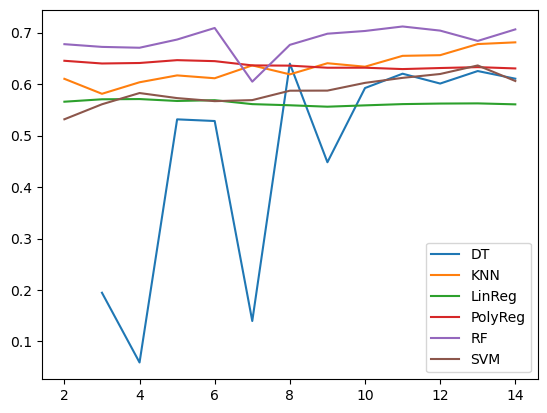

In [20]:
fig, ax = plt.subplots()
for model in np.unique(order_progression.MODEL):
    #if model == 'DT': continue
    data_filt = order_progression[order_progression.MODEL == model]
    data_filt = data_filt[data_filt['R2 TEST FS'] >= 0]
    ax.plot(data_filt.ORDER, data_filt['R2 TEST FS'], label=model)
ax.legend()